In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re


C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [52]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

# Load the data
file_path = '../../archive/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(file_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)


In [53]:
df.shape

(1600000, 6)

In [54]:

# Clean and preprocess the text
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'\W|\d', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into text
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text

# Apply preprocessing to the text column
df['processed_text'] = df['text'].apply(preprocess_text)



In [55]:
df['target_binary'] = df['target'].apply(lambda x: 1 if x == 4 else 0)


In [87]:

# Split data into training and testing sets
X = df['processed_text']
y = df['target_binary']

#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [88]:
X_train.shape

(1280000,)

In [96]:
%%time
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

#vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features and stop_words as needed
#X_train_tfidf = vectorizer.fit_transform(X_train)
#X_test_tfidf = vectorizer.transform(X_test)

CPU times: total: 2.83 s
Wall time: 10.6 s


In [97]:
%%time
# Initialize and train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

CPU times: total: 641 ms
Wall time: 2.13 s


LogisticRegression(max_iter=1000)

In [98]:
y_train_pred = model.predict(X_train_tfidf)
y_val_pred = model.predict(X_val_tfidf)
y_pred = model.predict(X_test_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print(classification_report(y_test, y_pred))

Training Accuracy: 0.77218046875
Validation Accuracy: 0.773015625
Test Accuracy: 0.7693875
              precision    recall  f1-score   support

           0       0.78      0.75      0.76    159494
           1       0.76      0.79      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [99]:
# Predictions
y_train_pred = model.predict(X_train_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {accuracy:.4f}')

Train Accuracy: 0.7722


In [100]:
# Predictions
y_val_pred = model.predict(X_val_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.7730


In [101]:

# Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.7694
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76    159494
           1       0.76      0.79      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



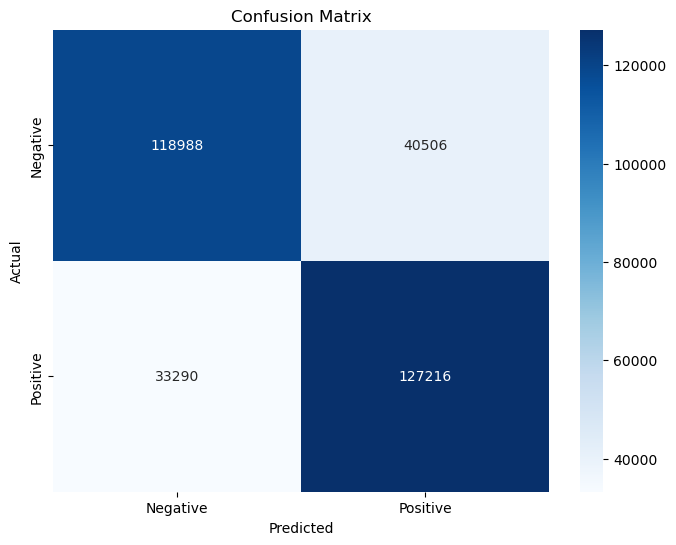

In [102]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

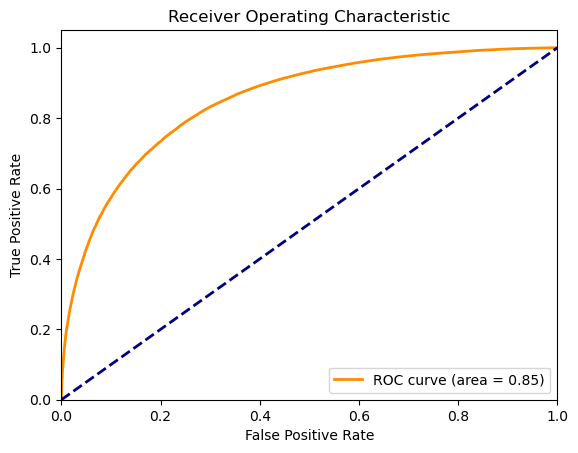

In [103]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1 (positive)
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [104]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distribution
param_dist = {
    'C': uniform(0.1, 100),  # Continuous distribution between 0.1 and 100
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)

# Fit the random search to the data
random_search.fit(X_train_tfidf, y_train)

# Best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'C': 0.6522117123602399, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.7701


In [107]:
# Train Predictions
y_train_pred = random_search.predict(X_train_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {accuracy:.8f}')

Train Accuracy: 0.77246328


In [109]:
# Validation Predictions
y_val_pred = random_search.predict(X_val_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.8f}')

Validation Accuracy: 0.77329297


In [110]:
# Testing Predictions
y_pred = random_search.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.8f}')

Accuracy: 0.76957500


### Save RandomSearch

In [112]:
import joblib
joblib_file = "model/random_search_model.pkl"
joblib.dump(random_search, joblib_file)

['model/random_search_model.pkl']

### Load RandomSearch

In [115]:
# Load the random search model from the file
random_search_loaded = joblib.load(joblib_file)

# Access the best parameters and score from the loaded model
best_params_loaded = random_search_loaded.best_params_
best_score_loaded = random_search_loaded.best_score_

print(f"Best Parameters: {best_params_loaded}")
print(f"Best Cross-Validation Accuracy: {best_score_loaded:.8f}")

Best Parameters: {'C': 0.6522117123602399, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.77013437


# Naive Bayesian Model


In [67]:
from sklearn.naive_bayes import MultinomialNB

In [68]:
%%time
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

CPU times: total: 31.2 ms
Wall time: 162 ms


MultinomialNB()

In [69]:
# Predictions
y_train_pred = model.predict(X_train_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_train, y_train_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7564


In [70]:
%%time
y_pred = model.predict(X_test_tfidf)

CPU times: total: 0 ns
Wall time: 20.9 ms


In [71]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.5317
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.48      0.50    159494
           1       0.53      0.59      0.56    160506

    accuracy                           0.53    320000
   macro avg       0.53      0.53      0.53    320000
weighted avg       0.53      0.53      0.53    320000



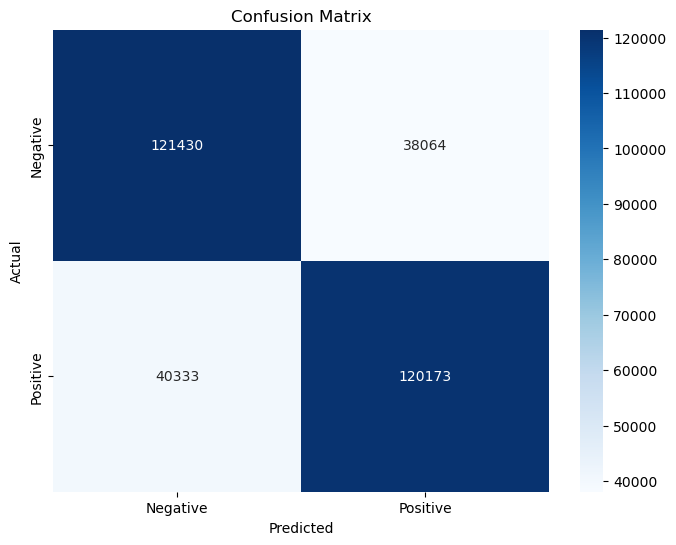

In [36]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

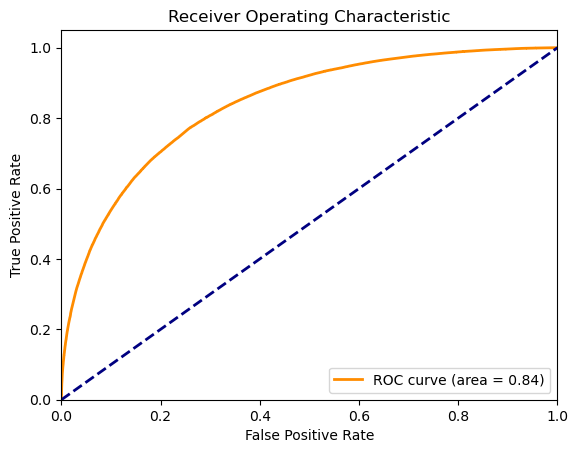

In [37]:
# Get predicted probabilities for class 1 (positive)
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()